# CNN CLASSIFICATION - SKIN CANCER

## 1. Loading Modules and Configuration Settings

In [1]:
import numpy as np
import tensorflow as tf
import random as rn

In [2]:
import os
os.environ['PYTHONHASHSEED'] = '0'
rn.seed(1254)
np.random.seed(37)
tf.random.set_seed(89)

# from keras import backend as K
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph = tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

tf.compat.v1.set_random_seed(12)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# tf.keras.utils.set_random_seed(1)
# tf.config.experimental.enable_op_determinism()

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator

import cv2 as cv
from skimage.io import imread, imshow

import os
import shutil

In [4]:
# PD Options

pd.set_option('display.min_rows', 5)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 4)

## 2. Loading Dataset

### 2.1 Original HAM10000 Dataset

In [5]:
### Original HAM10000 dataset CSV File.

dfham = pd.read_csv('ham_meta.csv')
print(f'Shape of the Original Dataset: {dfham.shape}')
dfham.head()

Shape of the Original Dataset: (10015, 7)


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk
1,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity
2,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk
3,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk
4,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest


### 2.2 Sample Image Data

Image File Name: ISIC_0026261.jpg
Shape of the image: (450, 600, 3)


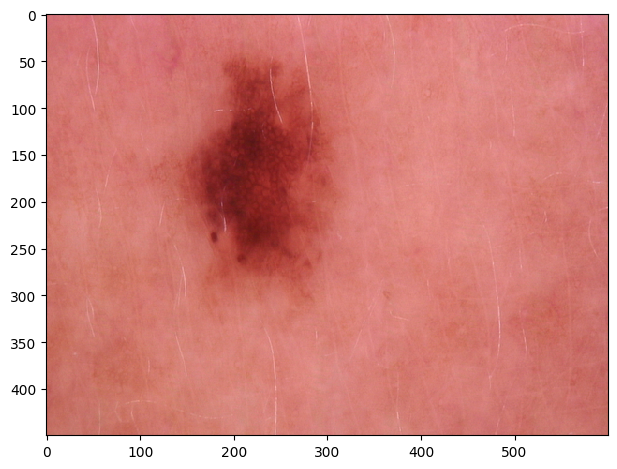

In [6]:
img = dfham['image_id'].sample().values[0]
img = f'{img}.jpg'
print(f'Image File Name: {img}')

img = imread(f'./data/{img}')
print(f'Shape of the image: {img.shape}')
imshow(img)

## 3. Dataset Augmentation Process

### 3.1 Reduced Features Dataset
#### After applying three operations on Original Dataset.

In [7]:
### Small HAM10000 dataset after selecting specific features.
dfs = dfham.loc[:,['image_id','dx']]

### Tagging the image as 'original' before augmentation.
### After augmentation, augmented (additional) images will be tagged as 'augmented'.
dfs['tag'] = 'original'

### Adding Extension '.jpg' to 'image_id' feature
dfs['image_id'] = dfs['image_id'].apply(lambda x: f'{x}.jpg')

print(f'Shape of the Reduced Feature Dataset: {dfs.shape}')
dfs.head()

Shape of the Reduced Feature Dataset: (10015, 3)


,image_id,dx,tag
0,ISIC_0024306.jpg,nv,original
1,ISIC_0024307.jpg,nv,original
2,ISIC_0024308.jpg,nv,original
3,ISIC_0024309.jpg,nv,original
4,ISIC_0024310.jpg,mel,original


### 3.2 Class Labels to be Augmented
#### NOTE: Selecting Class Labels Below Threshold Value.

In [8]:
### Class Distribution for 'dx' target feature.

labels = dfs['dx'].value_counts()
labels = dict(labels)
print('Class Distribution of "dx" feature ... \n')
for k,v in labels.items():
    print(f'"{k}" ---> {v}')

Class Distribution of "dx" feature ... 

"nv" ---> 6705
"mel" ---> 1113
"bkl" ---> 1099
"bcc" ---> 514
"akiec" ---> 327
"vasc" ---> 142
"df" ---> 115


In [9]:
### Threshold for augmentating 'image' class labels.

thresh = 1000
aug_labs = []

for k,v in labels.items():
    if v < thresh:
        aug_labs.append(k)
    else:
        continue

print(f'Threshold Value for Class Augmentation: {thresh} ...')
print(f'Class Labels below Threshold Value: {aug_labs}')

Threshold Value for Class Augmentation: 1000 ...
Class Labels below Threshold Value: ['bcc', 'akiec', 'vasc', 'df']


### 3.3 Image Data Generator Object and Augmentation Utility Function

#### 3.3.1 Image Data Generator Object

In [10]:
# generators

datagen = ImageDataGenerator(
                            #rescale=1./255,
                            rotation_range=25,
                            #width_shift_range=0.2,
                            #height_shift_range=0.2,
                            #shear_range=0.2,
                            zoom_range=0.2,
                            fill_mode='nearest',
                            horizontal_flip=True,
                            vertical_flip=True,
                        )

#### 3.3.2 Augmentation Utility Function

In [11]:
def label_data_gen(datagen, src, dest, prfx, nitems):
    
    batch=50
    size=(450,600)
       
    iters = (nitems/batch)

    i=0
    for batch in datagen.flow_from_directory(
                                                directory = src,      #    './set',
                                                batch_size = batch,
                                                color_mode="rgb",
                                                target_size = size,
                                                save_to_dir=dest,       # f'./set_gen/{label}',
                                                save_prefix=prfx,       # f'aug_{label}',
                                                save_format='jpg'
                                            ):
        i +=1
        if i>iters+1:
            break
    
    n = len(os.listdir(dest))
    if n!=0:
        print('Images generated successfully ... \n')
    else:
        print('Images generation failed ... \n')

#### 3.3.3 Folders Copy and Data Augmentation Process
##### NOTE: Copying one folder at a time for augmentation
##### 1. Copying label directory from "folders" to "set".
##### 2. Augmenting from "set" to "set_gen" into a label directory.
##### 3. Cleaning up "set" finally to remove the existing label directory and repeat (1,2,3) for the next class label.

In [12]:
curr_path=os.getcwd()
print(f'Current Working Directory: {curr_path} \n')

for lab in aug_labs:
    
    ### DATA COPY SECTION #######################################################
    ## Source
    print(f'Class Label: "{lab}" \n')
    
    print('DATA COPY SECTION')
    src_path = os.path.join(curr_path,'folders',lab)
    print(f'SRC: {src_path} has {len(os.listdir(src_path))} files ...')

    ## Destination
    dest_path = os.path.join(curr_path,'set',lab)
    #print(f'DEST: {dest_path} ... \n')

    ## COPY
    shutil.copytree(src_path,dest_path)
    print(f'DEST: {len(os.listdir(dest_path))} files copied to {dest_path} ... \n')


    ### DATA AUGMENTATION SECTION ###############################################
    print('DATA AUGMENTATION SECTION')
    ## Aug Source
    aug_src_path = os.path.join(curr_path,'set')
    print(f'AUG_SRC: {aug_src_path}')

    ## Aug Destination
    aug_dest_path = os.path.join(curr_path,'set_gen',lab)
    print(f'AUG_DEST: {aug_dest_path}')

    if os.path.exists(aug_dest_path):
        print('Path Exists ... \n')
    else:
        os.mkdir(aug_dest_path)
        print('Path Created ... \n')

    ## Aug Extra
    prfx = f'aug_{lab}'
    nitems=500          # No of images to be generated

    ##### Augmentation Function Call ############################################
    print('DATA GENERATION ...')
    label_data_gen(datagen, aug_src_path, aug_dest_path, prfx, nitems)

    ##### Augmentation Label Source Folder Clean Up
    print('DATA AUGMENTATION SOURCE CLEAN UP SECTION')
    aug_lab_src_path = os.path.join(aug_src_path,lab)
    if os.path.exists(aug_lab_src_path):
        print('Path Exists')
        shutil.rmtree(aug_lab_src_path)
        print(f'AUG_SRC: {aug_lab_src_path}, Path Removed... \n')
    else:
        print('Path Does not Exists... \n')

    print(f'--------------------------- Class Label: "{lab}" data generated ------------------------------- \n')
    

Current Working Directory: G:\ZZ-FINAL\ZZDEV\Z-COURSE-PROJ\PROJ\CNN-SK\sk 

Class Label: "bcc" 

DATA COPY SECTION
SRC: G:\ZZ-FINAL\ZZDEV\Z-COURSE-PROJ\PROJ\CNN-SK\sk\folders\bcc has 514 files ...
DEST: 514 files copied to G:\ZZ-FINAL\ZZDEV\Z-COURSE-PROJ\PROJ\CNN-SK\sk\set\bcc ... 

DATA AUGMENTATION SECTION
AUG_SRC: G:\ZZ-FINAL\ZZDEV\Z-COURSE-PROJ\PROJ\CNN-SK\sk\set
AUG_DEST: G:\ZZ-FINAL\ZZDEV\Z-COURSE-PROJ\PROJ\CNN-SK\sk\set_gen\bcc
Path Created ... 

DATA GENERATION ...
Found 514 images belonging to 1 classes.
Images generated successfully ... 

DATA AUGMENTATION SOURCE CLEAN UP SECTION
Path Exists
AUG_SRC: G:\ZZ-FINAL\ZZDEV\Z-COURSE-PROJ\PROJ\CNN-SK\sk\set\bcc, Path Removed... 

--------------------------- Class Label: "bcc" data generated ------------------------------- 

Class Label: "akiec" 

DATA COPY SECTION
SRC: G:\ZZ-FINAL\ZZDEV\Z-COURSE-PROJ\PROJ\CNN-SK\sk\folders\akiec has 327 files ...
DEST: 327 files copied to G:\ZZ-FINAL\ZZDEV\Z-COURSE-PROJ\PROJ\CNN-SK\sk\set\akiec ... 

### 3.4 DataFrame Entry of Augmented Images

#### 3.4.1 Setting Path and Labels

In [13]:
curr_path

'G:\\ZZ-FINAL\\ZZDEV\\Z-COURSE-PROJ\\PROJ\\CNN-SK\\sk'

In [14]:
data_path = os.path.join(curr_path,'set_gen')
data_path

'G:\\ZZ-FINAL\\ZZDEV\\Z-COURSE-PROJ\\PROJ\\CNN-SK\\sk\\set_gen'

In [15]:
dirs = os.listdir(data_path)
dirs

['akiec', 'bcc', 'df', 'vasc']

#### 3.4.2 Preparing Data Structure for the Data Frame Entry

In [16]:
image_ids = []
dxs = []
tags = []

In [17]:
for d in dirs:
    labdir = os.path.join(data_path,d)
    print(f'Class Label: "{d}"')
    
    files = os.listdir(labdir)
    print(f'{labdir} has {len(files)} files ... \n')
        
    for file in files:
        image_ids.append(file)
        dxs.append(d)
        tags.append('augmented')
    
    print('Done ............................................. \n')

Class Label: "akiec"
G:\ZZ-FINAL\ZZDEV\Z-COURSE-PROJ\PROJ\CNN-SK\sk\set_gen\akiec has 577 files ... 

Done ............................................. 

Class Label: "bcc"
G:\ZZ-FINAL\ZZDEV\Z-COURSE-PROJ\PROJ\CNN-SK\sk\set_gen\bcc has 564 files ... 

Done ............................................. 

Class Label: "df"
G:\ZZ-FINAL\ZZDEV\Z-COURSE-PROJ\PROJ\CNN-SK\sk\set_gen\df has 460 files ... 

Done ............................................. 

Class Label: "vasc"
G:\ZZ-FINAL\ZZDEV\Z-COURSE-PROJ\PROJ\CNN-SK\sk\set_gen\vasc has 568 files ... 

Done ............................................. 



#### 3.4.3 Augmented Dataset (DataFrame)

In [18]:
dfn = pd.DataFrame({'image_id':image_ids, 'dx':dxs, 'tag':tags})

In [19]:
print(f'Shape of the Augmented Dataset : {dfn.shape}')
dfn.head()

Shape of the Augmented Dataset : (2169, 3)


,image_id,dx,tag
0,aug_akiec_0_448592.jpg,akiec,augmented
1,aug_akiec_0_9116967.jpg,akiec,augmented
2,aug_akiec_100_1583555.jpg,akiec,augmented
3,aug_akiec_100_2844759.jpg,akiec,augmented
4,aug_akiec_101_1824611.jpg,akiec,augmented


#### 3.4.4 Combining Reduced and Augmented DataFrames

In [20]:
df_all = pd.concat([dfs,dfn], axis=0)

In [21]:
### Target Label Encoding for 'dx' target feature, for section 3.5.1

le = LabelEncoder()
df_all['Label'] = le.fit_transform(df_all['dx'])
print(f'Encoded Class Labels ... \n')
for l,v in zip(le.classes_,range(len(le.classes_))):
    print(f'Class Label: "{l}" ---> {v}.')

Encoded Class Labels ... 

Class Label: "akiec" ---> 0.
Class Label: "bcc" ---> 1.
Class Label: "bkl" ---> 2.
Class Label: "df" ---> 3.
Class Label: "mel" ---> 4.
Class Label: "nv" ---> 5.
Class Label: "vasc" ---> 6.


In [22]:
print(f'Shape of Final Dataset: {df_all.shape}')
df_all.head()

Shape of Final Dataset: (12184, 4)


,image_id,dx,tag,Label
0,ISIC_0024306.jpg,nv,original,5
1,ISIC_0024307.jpg,nv,original,5
2,ISIC_0024308.jpg,nv,original,5
3,ISIC_0024309.jpg,nv,original,5
4,ISIC_0024310.jpg,mel,original,4


In [23]:
df_all['tag'].value_counts()

tag
original     10015
augmented     2169
Name: count, dtype: int64

In [24]:
df_all['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc      1078
akiec     904
vasc      710
df        575
Name: count, dtype: int64

### 3.5 Grouping and Resampling the Sub Datasets to Balance the Dataset

#### 3.5.1 Grouping Data into Sub Datasets

In [25]:
df0 = df_all[df_all['Label'] == 0]
df1 = df_all[df_all['Label'] == 1]
df2 = df_all[df_all['Label'] == 2]
df3 = df_all[df_all['Label'] == 3]
df4 = df_all[df_all['Label'] == 4]
df5 = df_all[df_all['Label'] == 5]
df6 = df_all[df_all['Label'] == 6]

#### 3.5.2 Resampling 500 images for each Class Label (without replacement)

In [26]:
n_samples=500 

df0_bal = resample(df0, replace=False, n_samples=n_samples, random_state=46)    #
df1_bal = resample(df1, replace=False, n_samples=n_samples, random_state=46) 
df2_bal = resample(df2, replace=False, n_samples=n_samples, random_state=46)
df3_bal = resample(df3, replace=False, n_samples=n_samples, random_state=46)    #
df4_bal = resample(df4, replace=False, n_samples=n_samples, random_state=46)
df5_bal = resample(df5, replace=False, n_samples=n_samples, random_state=46)
df6_bal = resample(df6, replace=False, n_samples=n_samples, random_state=46)    #

#### 3.5.3 Creating Balanced DataFrame after Resampling

In [27]:
df_bal = pd.concat([df0_bal, df1_bal, df2_bal, df3_bal, df4_bal, df5_bal, df6_bal])

In [28]:
print(f'Shape of the Final Balanced Dataset: {df_bal.shape}')
df_bal.head()

Shape of the Final Balanced Dataset: (3500, 4)


,image_id,dx,tag,Label
7829,ISIC_0032135.jpg,akiec,original,0
5003,ISIC_0029309.jpg,akiec,original,0
1525,ISIC_0025831.jpg,akiec,original,0
117,aug_akiec_160_7013519.jpg,akiec,augmented,0
5869,ISIC_0030175.jpg,akiec,original,0


In [29]:
df_bal['Label'].value_counts()

Label
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: count, dtype: int64

In [30]:
df_bal.duplicated().sum()

0

### 3.6 Adding Image Path to Dataset

#### 3.6.1 Source Directory of all Images

In [31]:
img_src = './all_data_gen'
print(f'Image Source Directory: {img_src}')

Image Source Directory: ./all_data_gen


#### 3.6.2 Adding Path to Dataset

In [32]:
df_bal['path'] = df_bal['image_id'].apply(lambda x: os.path.join(img_src,x))

In [33]:
df_bal.head()

,image_id,dx,tag,Label,path
7829,ISIC_0032135.jpg,akiec,original,0,./all_data_gen\ISIC_0032135.jpg
5003,ISIC_0029309.jpg,akiec,original,0,./all_data_gen\ISIC_0029309.jpg
1525,ISIC_0025831.jpg,akiec,original,0,./all_data_gen\ISIC_0025831.jpg
117,aug_akiec_160_7013519.jpg,akiec,augmented,0,./all_data_gen\aug_akiec_160_7013519.jpg
5869,ISIC_0030175.jpg,akiec,original,0,./all_data_gen\ISIC_0030175.jpg


### 3.7. Saving the Final Balanced DataFrame into CSV file.

In [34]:
df_bal.to_csv('ham_meta_final.csv', index=False)
print('CSV file created successfully ...')

CSV file created successfully ...


### 3.8 Copying Aug Images to Source (all data gen) folder 

#### 3.8.1 Setting Path and Labels

In [35]:
curr_path=os.getcwd()
curr_path

'G:\\ZZ-FINAL\\ZZDEV\\Z-COURSE-PROJ\\PROJ\\CNN-SK\\sk'

In [36]:
src_cp = os.path.join(curr_path,'set_gen')
src_cp

'G:\\ZZ-FINAL\\ZZDEV\\Z-COURSE-PROJ\\PROJ\\CNN-SK\\sk\\set_gen'

In [37]:
dirs = os.listdir(src_cp)
dirs

['akiec', 'bcc', 'df', 'vasc']

In [38]:
dest_cp = os.path.join(curr_path,'all_data_gen')
dest_cp

'G:\\ZZ-FINAL\\ZZDEV\\Z-COURSE-PROJ\\PROJ\\CNN-SK\\sk\\all_data_gen'

#### 3.8.2 Augmented Data Copy Process

In [39]:
for d in dirs:
    print(f'Augmented Class Label: "{d}" ')
    lab_src_cp = os.path.join(src_cp,d)
    print('SOURCE ...')
    print(lab_src_cp)
    files = os.listdir(lab_src_cp)
    print(f'No. of Files in "{d}" folder: {len(files)} \n')
    
    #lab_dest_cp = os.path.join(dest_cp,d)         # use lab_dest_cp, if folder wise copy is required from SOURCE to DESTINATION.
    print('DESTINATION ...')
    print(dest_cp)
    if os.path.exists(dest_cp):
        print('Path Exists ... \n')
    else:                                        # use else: block, if path is not existing already for main destination folder.
        print('Path Does not Exist')
        print('Creating Path ...')
        os.mkdir(dest_cp)                        # lab_dest_cp, for folder wise data copy
        print('Done  ... \n')
        
    print('INITIATING File(s) Copy ... \n')
    for file in files:
        shutil.copy2(os.path.join(lab_src_cp,file),dest_cp)
        
    print(f'"{len(files)}" files copied to path: "{dest_cp}"... \n')
    
    
    ############################################################ Path Clean Up Code ############################
    print('CLEANING UP ...')
    shutil.rmtree(lab_src_cp)        
    print(f'"{lab_src_cp}" : Path Removed ... \n')
    
    print(f'-------------- Class Label: "{d}" data Copied ------------------- \n')

Augmented Class Label: "akiec" 
SOURCE ...
G:\ZZ-FINAL\ZZDEV\Z-COURSE-PROJ\PROJ\CNN-SK\sk\set_gen\akiec
No. of Files in "akiec" folder: 577 

DESTINATION ...
G:\ZZ-FINAL\ZZDEV\Z-COURSE-PROJ\PROJ\CNN-SK\sk\all_data_gen
Path Exists ... 

INITIATING File(s) Copy ... 

"577" files copied to path: "G:\ZZ-FINAL\ZZDEV\Z-COURSE-PROJ\PROJ\CNN-SK\sk\all_data_gen"... 

CLEANING UP ...
"G:\ZZ-FINAL\ZZDEV\Z-COURSE-PROJ\PROJ\CNN-SK\sk\set_gen\akiec" : Path Removed ... 

-------------- Class Label: "akiec" data Copied ------------------- 

Augmented Class Label: "bcc" 
SOURCE ...
G:\ZZ-FINAL\ZZDEV\Z-COURSE-PROJ\PROJ\CNN-SK\sk\set_gen\bcc
No. of Files in "bcc" folder: 564 

DESTINATION ...
G:\ZZ-FINAL\ZZDEV\Z-COURSE-PROJ\PROJ\CNN-SK\sk\all_data_gen
Path Exists ... 

INITIATING File(s) Copy ... 

"564" files copied to path: "G:\ZZ-FINAL\ZZDEV\Z-COURSE-PROJ\PROJ\CNN-SK\sk\all_data_gen"... 

CLEANING UP ...
"G:\ZZ-FINAL\ZZDEV\Z-COURSE-PROJ\PROJ\CNN-SK\sk\set_gen\bcc" : Path Removed ... 

-------------- C

## 4. Displaying Sample Images

### 4.1 Final Dataset

In [40]:
df = pd.read_csv('ham_meta_final.csv')
df.head()

,image_id,dx,tag,Label,path
0,ISIC_0032135.jpg,akiec,original,0,./all_data_gen\ISIC_0032135.jpg
1,ISIC_0029309.jpg,akiec,original,0,./all_data_gen\ISIC_0029309.jpg
2,ISIC_0025831.jpg,akiec,original,0,./all_data_gen\ISIC_0025831.jpg
3,aug_akiec_160_7013519.jpg,akiec,augmented,0,./all_data_gen\aug_akiec_160_7013519.jpg
4,ISIC_0030175.jpg,akiec,original,0,./all_data_gen\ISIC_0030175.jpg


### 4.2 Original Dataset Image

Class Label: "NV"
Image ID: ISIC_0028589.jpg
Image Path: ./all_data_gen\ISIC_0028589.jpg 

Shape of the Image: (450, 600, 3)


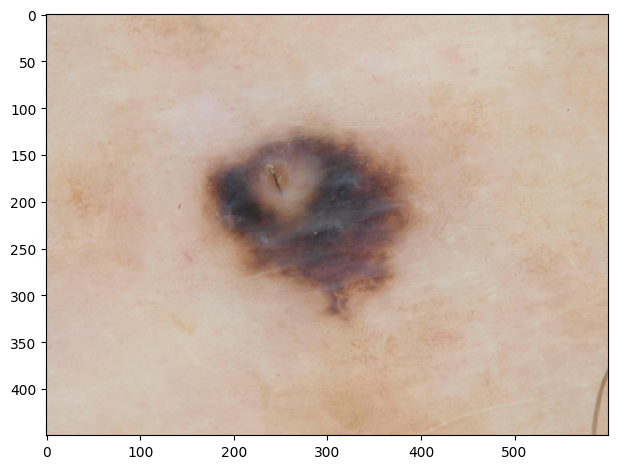

In [41]:
filt = (df['tag']=='original')

data = df.loc[filt,['dx','image_id','path']].sample().values.tolist()

print(f'Class Label: "{str.upper(data[0][0])}"')
print(f'Image ID: {data[0][1]}')
print(f'Image Path: {data[0][2]} \n')

img = imread(data[0][2])
print(f'Shape of the Image: {img.shape}')
imshow(img)

### 4.3 Augmented Dataset Image

Class Label: "BCC"
Image ID: aug_bcc_440_5632613.jpg
Image Path: ./all_data_gen\aug_bcc_440_5632613.jpg 

Shape of the Image: (450, 600, 3)


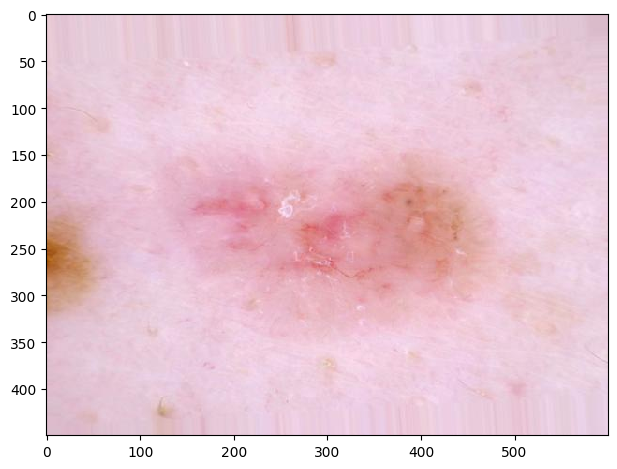

In [42]:
filt = (df['tag']=='augmented')

data = df.loc[filt,['dx','image_id','path']].sample().values.tolist()

print(f'Class Label: "{str.upper(data[0][0])}"')
print(f'Image ID: {data[0][1]}')
print(f'Image Path: {data[0][2]} \n')

img = imread(data[0][2])
print(f'Shape of the Image: {img.shape}')
imshow(img)